In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import math

from collections import OrderedDict


import scanpy as sc
import os


In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )

adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')

In [3]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        self.n_cat = adata.obs['sample'].nunique()
        self.labels = torch.tensor(adata.obs['leiden_scVI_res0.9'].cat.codes.values).to(torch.int64)   # cell type labels
        self.n_labels = adata.obs['leiden_scVI_res0.9'].nunique()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
adipose_dataset = scDataset(adipose_sn_ad)
data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
a = next(iter(data_loader))
    

In [4]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, latent_dim=1280, hidden_dim=1280, hidden_layers=2):
        super(Encoder_x, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[latent_dim, latent_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, cell_type_one_hot=None):
        if cell_type_one_hot is not None:
            x = torch.cat([x, cell_type_one_hot], dim=1) # cell_type_one_hot is the one_hot encoded cell_type_index  
        x = self.layers(x)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_l(nn.Module):
    """_summary_
        This encodes the library size, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=2):
        super(Encoder_l, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[latent_dim, latent_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        x = self.layers(x)
        ql_mean = self.linear_mean(x)
        ql_var = torch.exp(self.linear_var(x))
        #library_dist = torch.distributions.Normal(ql_mean, ql_var.sqrt())
        return ql_mean, ql_var #, library_dist
    

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=2):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim))  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                                   nn.ReLU())
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        
        px_dropout = self.px_dropout_decoder(x)
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Adapted From `https://github.com/scverse/scvi-tools`  with minor modifications
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.nan_to_num(torch.lgamma(x + theta), posinf=0.)
        - torch.nan_to_num(torch.lgamma(theta), posinf=0.)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    # print(f"x[0, 0] is: {x[0,0]}")
    # print(f"torch.lgamma(x + theta)[0, 0] is: {torch.lgamma(x + theta)[0,0]}")
    # print(f"torch.lgamma(theta)[0, 0] is: {torch.lgamma(theta)[0,0]}")

    res = mul_case_zero + mul_case_non_zero

    return res



def log_nb_positive(
    x: torch.Tensor ,
    mu: torch.Tensor ,
    theta: torch.Tensor ,
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
) -> torch.Tensor :
    """Log likelihood (scalar) of a minibatch according to a nb model.

    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res


In [8]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, total_cat, total_cell_type, cell_type_encode=True):
        super(snRNAseqVAE, self).__init__()

        self.cell_type_encode = cell_type_encode 
        
        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
        
        #self.reconst_loss_fun = -log_zinb_positive
        
        if cell_type_encode:
            encoder_x_input_dim = input_dim + total_cell_type
        else:
            encoder_x_input_dim = input_dim
        self.encoder_x = Encoder_x(encoder_x_input_dim, latent_dim)
        
        #self.encoder_l = Encoder_l(input_dim, 1)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim)
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        if self.cell_type_encode:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        else:
            qz_mean, qz_var = self.encoder_x(x)
        #ql_mean, ql_var = self.encoder_l(x)
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        #l = torch.distributions.Normal(ql_mean, ql_var.sqrt()).rsample()
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)
        #return qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout  # encode library size 
        return qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    
    def forward(self, x, local_l_mean, local_l_var, cat_one_hot, cell_type_one_hot):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            local_l_var (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]

        Returns:
            _type_: _description_
        """
        #local_l_mean =  x.sum(axis=1) outside of this function
        #local_l_var = 0 # should this be within batch? YES as it is observed and varies from batch to batch. FInish outside of this function

        
        #qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot)  # encode library size output 
        qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        #l_dist = torch.distributions.Normal(ql_mean, ql_var)
        kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        #kl_l = torch.distributions.kl.kl_divergence(l_dist, torch.distributions.Normal(local_l_mean, local_l_var.sqrt())).sum(axis=1)
        #kl_l = torch.tensor([0.])
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).mean(axis=-1)
        # print(f"reconst_loss is {reconst_loss}")
        # print(f"reconst_loss shape if of: {reconst_loss.shape}")
        # print(f"kl_z shape if of: {kl_z.shape}")
        # print(f"kl_l shape if of: {kl_l.shape}")
        
        #return (reconst_loss + kl_z + kl_l).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()
        return (reconst_loss + kl_z ).mean()

#### Change to code cell to run 
#### DEBUGGING
###### prepare data
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

x, cat_onehot, label_onehot, local_library_mean, local_library_var = next(iter(data_loader))

loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot)

for i in loss:
    print(i)

In [9]:
## Training 
def trainning(model, train_loader, device, optimizer, n_epochs=100):
    model = model.to(device)
    model.train()
    train_loss = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            label_onehot = label_onehot.to(device)
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot) 
            loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        print("Epoch: ", epoch, "Loss: ", total_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss

In [10]:
## Data
train_data = adipose_sn_ad#[adipose_sn_ad.obs['sample'] == '03_SQ', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=500, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=30, total_cat=total_cat, total_cell_type=total_cell_type, cell_type_encode=False)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

train_loss = trainning(model, data_loader, device='cuda', optimizer=optimizer, n_epochs=100)

  1%|          | 1/100 [00:03<05:39,  3.42s/it]

Epoch:  0 Loss:  0.49340171530173066


  2%|▏         | 2/100 [00:06<05:22,  3.29s/it]

Epoch:  1 Loss:  0.3735472171912702


  3%|▎         | 3/100 [00:09<05:21,  3.31s/it]

Epoch:  2 Loss:  0.3500144106618474


  4%|▍         | 4/100 [00:13<05:17,  3.30s/it]

Epoch:  3 Loss:  0.3782054368783249


  5%|▌         | 5/100 [00:16<05:13,  3.30s/it]

Epoch:  4 Loss:  0.3389149733473746


  6%|▌         | 6/100 [00:19<05:07,  3.27s/it]

Epoch:  5 Loss:  0.32470425004872044


  7%|▋         | 7/100 [00:23<05:04,  3.28s/it]

Epoch:  6 Loss:  0.3472729301017322


  8%|▊         | 8/100 [00:26<04:59,  3.25s/it]

Epoch:  7 Loss:  0.31479849498928264


  9%|▉         | 9/100 [00:29<04:57,  3.27s/it]

Epoch:  8 Loss:  0.3087658309953266


 10%|█         | 10/100 [00:32<04:54,  3.28s/it]

Epoch:  9 Loss:  0.30464670823866064


 11%|█         | 11/100 [00:36<04:52,  3.28s/it]

Epoch:  10 Loss:  0.3012104280962703


 12%|█▏        | 12/100 [00:39<04:46,  3.25s/it]

Epoch:  11 Loss:  0.2981484171547247


 13%|█▎        | 13/100 [00:42<04:40,  3.23s/it]

Epoch:  12 Loss:  0.29546977692608084


 14%|█▍        | 14/100 [00:45<04:39,  3.25s/it]

Epoch:  13 Loss:  0.29301502827680515


 15%|█▌        | 15/100 [00:49<04:36,  3.25s/it]

Epoch:  14 Loss:  0.29080829974473194


 16%|█▌        | 16/100 [00:52<04:33,  3.26s/it]

Epoch:  15 Loss:  0.28886055578006786


 17%|█▋        | 17/100 [00:55<04:28,  3.24s/it]

Epoch:  16 Loss:  0.28693276267038303


 18%|█▊        | 18/100 [00:58<04:26,  3.25s/it]

Epoch:  17 Loss:  0.2851935579451952


 19%|█▉        | 19/100 [01:01<04:21,  3.22s/it]

Epoch:  18 Loss:  0.28358940629476914


 20%|██        | 20/100 [01:05<04:19,  3.24s/it]

Epoch:  19 Loss:  0.2820647724726227


 21%|██        | 21/100 [01:08<04:17,  3.25s/it]

Epoch:  20 Loss:  0.2806864130530464


 22%|██▏       | 22/100 [01:11<04:12,  3.23s/it]

Epoch:  21 Loss:  0.2794215606337183


 23%|██▎       | 23/100 [01:15<04:10,  3.25s/it]

Epoch:  22 Loss:  0.27824842293610735


 24%|██▍       | 24/100 [01:18<04:05,  3.23s/it]

Epoch:  23 Loss:  0.27711981308929035


 25%|██▌       | 25/100 [01:21<04:04,  3.26s/it]

Epoch:  24 Loss:  0.2761030493073919


 26%|██▌       | 26/100 [01:24<03:59,  3.24s/it]

Epoch:  25 Loss:  0.275093292629116


 27%|██▋       | 27/100 [01:28<03:58,  3.26s/it]

Epoch:  26 Loss:  0.27415213784140147


 28%|██▊       | 28/100 [01:31<03:53,  3.24s/it]

Epoch:  27 Loss:  0.2732131079341588


 29%|██▉       | 29/100 [01:34<03:51,  3.26s/it]

Epoch:  28 Loss:  0.2723660204517707


 30%|███       | 30/100 [01:37<03:48,  3.27s/it]

Epoch:  29 Loss:  0.2715808796497543


 31%|███       | 31/100 [01:41<03:46,  3.28s/it]

Epoch:  30 Loss:  0.27081871095500637


 32%|███▏      | 32/100 [01:44<03:40,  3.25s/it]

Epoch:  31 Loss:  0.27004984046301145


 33%|███▎      | 33/100 [01:47<03:36,  3.23s/it]

Epoch:  32 Loss:  0.26935395288668323


 34%|███▍      | 34/100 [01:50<03:33,  3.24s/it]

Epoch:  33 Loss:  0.26870808733648127


 35%|███▌      | 35/100 [01:54<03:30,  3.25s/it]

Epoch:  34 Loss:  0.2680480350855361


 36%|███▌      | 36/100 [01:57<03:28,  3.25s/it]

Epoch:  35 Loss:  0.2674353088806854


 37%|███▋      | 37/100 [02:00<03:23,  3.23s/it]

Epoch:  36 Loss:  0.26681613968162055


 38%|███▊      | 38/100 [02:03<03:21,  3.24s/it]

Epoch:  37 Loss:  0.2662497445773543


 39%|███▉      | 39/100 [02:06<03:16,  3.23s/it]

Epoch:  38 Loss:  0.26568511680940565


 40%|████      | 40/100 [02:10<03:14,  3.24s/it]

Epoch:  39 Loss:  0.2650811110487145


 41%|████      | 41/100 [02:13<03:12,  3.26s/it]

Epoch:  40 Loss:  0.26484038664048976


 42%|████▏     | 42/100 [02:16<03:08,  3.26s/it]

Epoch:  41 Loss:  0.26438098160152357


 43%|████▎     | 43/100 [02:19<03:04,  3.23s/it]

Epoch:  42 Loss:  0.2636345153611698


 44%|████▍     | 44/100 [02:23<03:00,  3.21s/it]

Epoch:  43 Loss:  0.26311071911889516


 45%|████▌     | 45/100 [02:26<02:57,  3.23s/it]

Epoch:  44 Loss:  0.26265421296271046


 46%|████▌     | 46/100 [02:29<02:54,  3.24s/it]

Epoch:  45 Loss:  0.2621658658504151


 47%|████▋     | 47/100 [02:32<02:52,  3.25s/it]

Epoch:  46 Loss:  0.2616823168910956


 48%|████▊     | 48/100 [02:36<02:47,  3.22s/it]

Epoch:  47 Loss:  0.26126449804208923


 49%|████▉     | 49/100 [02:39<02:44,  3.23s/it]

Epoch:  48 Loss:  0.26095265583292154


 50%|█████     | 50/100 [02:42<02:40,  3.21s/it]

Epoch:  49 Loss:  0.26039067339779953


 51%|█████     | 51/100 [02:45<02:38,  3.24s/it]

Epoch:  50 Loss:  0.2599567635968495


 52%|█████▏    | 52/100 [02:49<02:35,  3.24s/it]

Epoch:  51 Loss:  0.25951946913944873


 53%|█████▎    | 53/100 [02:52<02:31,  3.22s/it]

Epoch:  52 Loss:  0.2591814100951626


 54%|█████▍    | 54/100 [02:55<02:28,  3.23s/it]

Epoch:  53 Loss:  0.2587959730181466


 55%|█████▌    | 55/100 [02:58<02:24,  3.21s/it]

Epoch:  54 Loss:  0.25843277816357235


 56%|█████▌    | 56/100 [03:01<02:22,  3.23s/it]

Epoch:  55 Loss:  0.25805988840842514


 57%|█████▋    | 57/100 [03:05<02:19,  3.24s/it]

Epoch:  56 Loss:  0.2576694410880295


 58%|█████▊    | 58/100 [03:08<02:16,  3.26s/it]

Epoch:  57 Loss:  0.25732358580643544


 59%|█████▉    | 59/100 [03:11<02:12,  3.23s/it]

Epoch:  58 Loss:  0.2569619949195492


 60%|██████    | 60/100 [03:14<02:09,  3.24s/it]

Epoch:  59 Loss:  0.25657512075947914


 61%|██████    | 61/100 [03:18<02:06,  3.24s/it]

Epoch:  60 Loss:  0.25625323918595744


 62%|██████▏   | 62/100 [03:21<02:04,  3.27s/it]

Epoch:  61 Loss:  0.2558415620221516


 63%|██████▎   | 63/100 [03:24<02:02,  3.30s/it]

Epoch:  62 Loss:  0.25563262930411973


 64%|██████▍   | 64/100 [03:28<01:59,  3.31s/it]

Epoch:  63 Loss:  0.2553410257599997


 65%|██████▌   | 65/100 [03:31<01:57,  3.35s/it]

Epoch:  64 Loss:  0.2549092880544368


 66%|██████▌   | 66/100 [03:34<01:53,  3.33s/it]

Epoch:  65 Loss:  0.2546429799639442


 67%|██████▋   | 67/100 [03:38<01:49,  3.32s/it]

Epoch:  66 Loss:  0.25436249111643


 68%|██████▊   | 68/100 [03:41<01:45,  3.30s/it]

Epoch:  67 Loss:  0.25403896602017156


 69%|██████▉   | 69/100 [03:44<01:42,  3.30s/it]

Epoch:  68 Loss:  0.25374281441981206


 70%|███████   | 70/100 [03:48<01:38,  3.29s/it]

Epoch:  69 Loss:  0.25345890929273673


 71%|███████   | 71/100 [03:51<01:35,  3.30s/it]

Epoch:  70 Loss:  0.25316396623515014


 72%|███████▏  | 72/100 [03:54<01:32,  3.30s/it]

Epoch:  71 Loss:  0.25288742583956614


 73%|███████▎  | 73/100 [03:57<01:28,  3.30s/it]

Epoch:  72 Loss:  0.25261467199228455


 74%|███████▍  | 74/100 [04:01<01:25,  3.28s/it]

Epoch:  73 Loss:  0.25371776374705723


 75%|███████▌  | 75/100 [04:04<01:21,  3.28s/it]

Epoch:  74 Loss:  0.25276403229558064


 76%|███████▌  | 76/100 [04:07<01:18,  3.29s/it]

Epoch:  75 Loss:  0.25230954162609043


 77%|███████▋  | 77/100 [04:11<01:15,  3.29s/it]

Epoch:  76 Loss:  0.25196092278602417


 78%|███████▊  | 78/100 [04:14<01:14,  3.41s/it]

Epoch:  77 Loss:  0.2516274919335762


 79%|███████▉  | 79/100 [04:17<01:10,  3.36s/it]

Epoch:  78 Loss:  0.2513511897263567


 80%|████████  | 80/100 [04:21<01:07,  3.38s/it]

Epoch:  79 Loss:  0.2510879918974772


 81%|████████  | 81/100 [04:24<01:04,  3.40s/it]

Epoch:  80 Loss:  0.25082772436520356


 82%|████████▏ | 82/100 [04:28<01:00,  3.37s/it]

Epoch:  81 Loss:  0.2506178031058124


 83%|████████▎ | 83/100 [04:31<00:56,  3.34s/it]

Epoch:  82 Loss:  0.250331221650658


 84%|████████▍ | 84/100 [04:34<00:52,  3.31s/it]

Epoch:  83 Loss:  0.2501395405217838


 85%|████████▌ | 85/100 [04:37<00:49,  3.32s/it]

Epoch:  84 Loss:  0.24987372423239637


 86%|████████▌ | 86/100 [04:41<00:45,  3.28s/it]

Epoch:  85 Loss:  0.24965618831220637


 87%|████████▋ | 87/100 [04:44<00:43,  3.33s/it]

Epoch:  86 Loss:  0.24945484156186662


 88%|████████▊ | 88/100 [04:48<00:40,  3.35s/it]

Epoch:  87 Loss:  0.24919602852523998


 89%|████████▉ | 89/100 [04:51<00:37,  3.41s/it]

Epoch:  88 Loss:  0.24898612785958843


 90%|█████████ | 90/100 [04:54<00:33,  3.37s/it]

Epoch:  89 Loss:  0.2487913111873557


 91%|█████████ | 91/100 [04:58<00:30,  3.38s/it]

Epoch:  90 Loss:  0.24854016578180738


 92%|█████████▏| 92/100 [05:01<00:26,  3.35s/it]

Epoch:  91 Loss:  0.248326288326905


 93%|█████████▎| 93/100 [05:05<00:23,  3.42s/it]

Epoch:  92 Loss:  0.2481824718625023


 94%|█████████▍| 94/100 [05:08<00:20,  3.38s/it]

Epoch:  93 Loss:  0.24791283702498743


 95%|█████████▌| 95/100 [05:11<00:16,  3.38s/it]

Epoch:  94 Loss:  0.24771861520627242


 96%|█████████▌| 96/100 [05:15<00:13,  3.39s/it]

Epoch:  95 Loss:  0.24753293114599217


 97%|█████████▋| 97/100 [05:18<00:10,  3.43s/it]

Epoch:  96 Loss:  0.24732581540691048


 98%|█████████▊| 98/100 [05:22<00:06,  3.48s/it]

Epoch:  97 Loss:  0.24714978152279105


 99%|█████████▉| 99/100 [05:25<00:03,  3.41s/it]

Epoch:  98 Loss:  0.2469587531150057


100%|██████████| 100/100 [05:28<00:00,  3.29s/it]

Epoch:  99 Loss:  0.24675225508346987


In [12]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [13]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')

In [14]:
sc.tl.umap(train_data_2)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


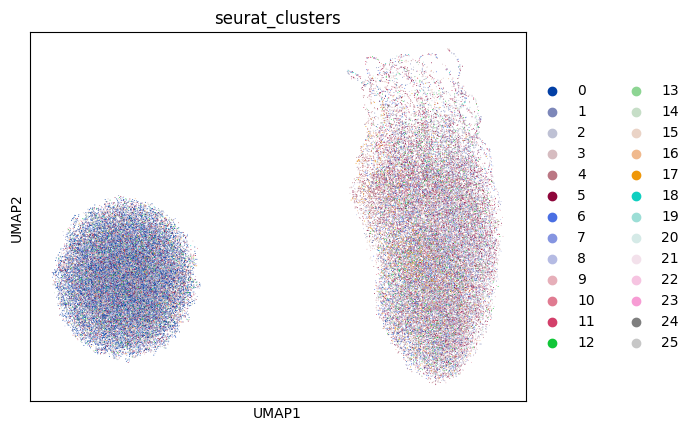

In [15]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


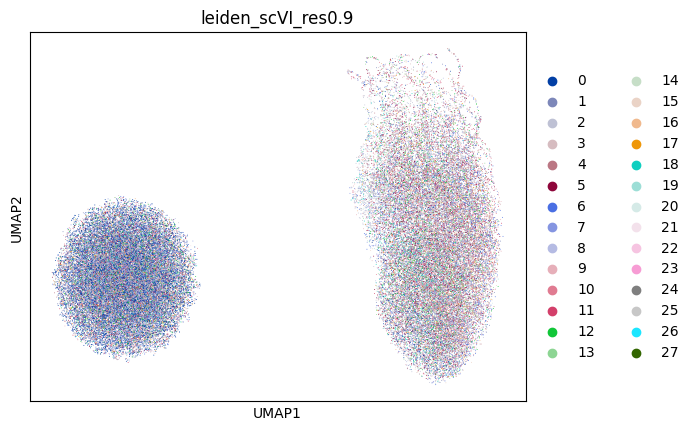

In [16]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

In [97]:
sc.pp.neighbors(train_data, use_rep='X_scVI')
sc.tl.umap(train_data)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


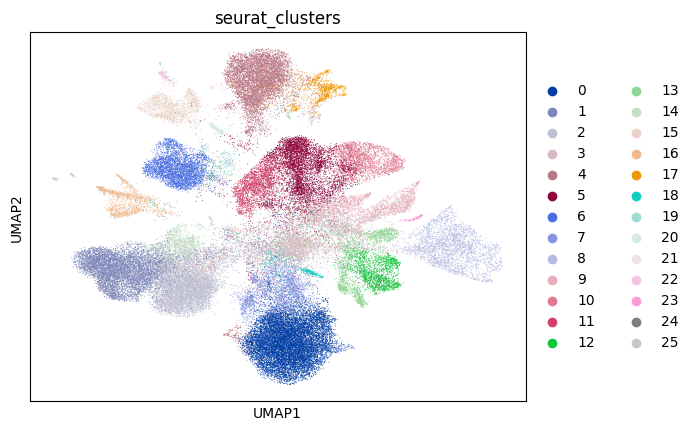

In [98]:
sc.pl.umap(train_data, color=['seurat_clusters'] )

In [60]:
#adipose_sn_ad_sp2.write_h5ad("/home/syyang/GitRepo/cs294/finalproject/script/adipose_with_VAE20270427.h5ad")

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


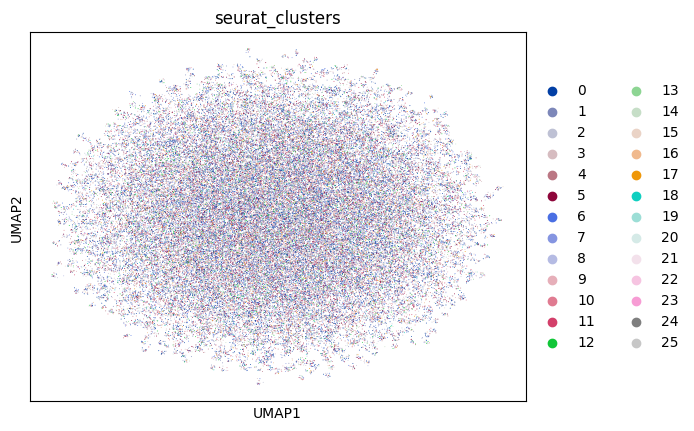

In [34]:
sc.pl.umap(adipose_sn_ad_sp2, color=['seurat_clusters'] )